# Implementation of "Perceptual Losses for Real-Time Style Transfer and Super-Resolution"

### 1. Imports

In [1]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import time

/home/dikatok/miniconda3/envs/deeplearning/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 2. Configuration

In [2]:
STYLE_IMG = "../test_images/styles/stars2.jpg"
CONTENT_IMG = "../test_images/contents/venice-boat.jpg"
CONTENT_DIR = "../contents/"
VGG_WEIGHT = "../vgg16_weights.npz"
LOG_DIR = "./logs"
MODEL_DIR = "./models"
CKPT_DIR = "./ckpts"

NUM_EPOCHS = 2
LEARNING_RATE = 1e-3
CONTENT_BATCH_SIZE = 4
STYLE_BATCH_SIZE = 1
LOG_ITER = 100
SAMPLE_ITER = 100
STYLE_SIZE = 256
CONTENT_SIZE = 256

CONTENT_LOSS_WEIGHT = 1
STYLE_LOSS_WEIGHT = 5

### 3. Load style image

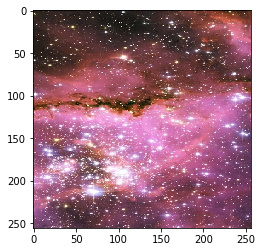

In [3]:
style_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(STYLE_IMG, target_size=(STYLE_SIZE,STYLE_SIZE)))

plt.imshow(style_image / 255)
plt.show()

### 4. VGG

In [4]:
def vgg16(x, weights):
    # substract imagenet mean
    mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='imagenet_mean')
    x = x - mean
    
    with tf.variable_scope("vgg16", reuse=tf.AUTO_REUSE):
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_1_W"]), trainable=False, name='conv1_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_1_b"]), trainable=False, name='conv1_1_b')
            conv1_1 = tf.nn.conv2d(x, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_1 = tf.nn.bias_add(conv1_1, biases)
            conv1_1 = tf.nn.relu(conv1_1, name=scope)

        with tf.name_scope('conv1_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv1_2_W"]), trainable=False, name='conv1_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv1_2_b"]), trainable=False, name='conv1_2_b')
            conv1_2 = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv1_2 = tf.nn.bias_add(conv1_2, biases)
            conv1_2 = tf.nn.relu(conv1_2, name=scope)

        pool1 = tf.nn.avg_pool(conv1_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', 
                               name='pool1')

        with tf.name_scope('conv2_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_1_W"]), trainable=False, name='conv2_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_1_b"]), trainable=False, name='conv2_1_b')
            conv2_1 = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_1 = tf.nn.bias_add(conv2_1, biases)
            conv2_1 = tf.nn.relu(conv2_1, name=scope)

        with tf.name_scope('conv2_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv2_2_W"]), trainable=False, name='conv2_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv2_2_b"]), trainable=False, name='conv2_2_b')
            conv2_2 = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv2_2 = tf.nn.bias_add(conv2_2, biases)
            conv2_2 = tf.nn.relu(conv2_2, name=scope)

        pool2 = tf.nn.avg_pool(conv2_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool2')

        with tf.name_scope('conv3_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_1_W"]), trainable=False, name='conv3_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_1_b"]), trainable=False, name='conv3_1_b')
            conv3_1 = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_1 = tf.nn.bias_add(conv3_1, biases)
            conv3_1 = tf.nn.relu(conv3_1, name=scope)

        with tf.name_scope('conv3_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_2_W"]), trainable=False, name='conv3_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_2_b"]), trainable=False, name='conv3_2_b')
            conv3_2 = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_2 = tf.nn.bias_add(conv3_2, biases)
            conv3_2 = tf.nn.relu(conv3_2, name=scope)

        with tf.name_scope('conv3_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv3_3_W"]), trainable=False, name='conv3_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv3_3_b"]), trainable=False, name='conv3_3_b')
            conv3_3 = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv3_3 = tf.nn.bias_add(conv3_3, biases)
            conv3_3 = tf.nn.relu(conv3_3, name=scope)

        pool3 = tf.nn.avg_pool(conv3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME',
                               name='pool3')

        with tf.name_scope('conv4_1') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_1_W"]), trainable=False, name='conv4_1_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_1_b"]), trainable=False, name='conv4_1_b')
            conv4_1 = tf.nn.conv2d(pool3, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_1 = tf.nn.bias_add(conv4_1, biases)
            conv4_1 = tf.nn.relu(conv4_1, name=scope)

        with tf.name_scope('conv4_2') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_2_W"]), trainable=False, name='conv4_2_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_2_b"]), trainable=False, name='conv4_2_b')
            conv4_2 = tf.nn.conv2d(conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_2 = tf.nn.bias_add(conv4_2, biases)
            conv4_2 = tf.nn.relu(conv4_2, name=scope)

        with tf.name_scope('conv4_3') as scope:
            kernel = tf.get_variable(initializer=tf.constant(weights["conv4_3_W"]), trainable=False, name='conv4_3_W')
            biases = tf.get_variable(initializer=tf.constant(weights["conv4_3_b"]), trainable=False, name='conv4_3_b')
            conv4_3 = tf.nn.conv2d(conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            conv4_3 = tf.nn.bias_add(conv4_3, biases)
            conv4_3 = tf.nn.relu(conv4_3, name=scope)
            
    return conv1_2, conv2_2, conv3_3, conv4_3

### 5. Transformation net

Transformation network enables us to transfer style with significant inference time reduction (compared to optimization method) and relatively small model size. Loss network such as pre-trained VGG is only used during training as guiding network. Below is the overall architecture introduced in the paper including the loss network.

<img src="./assets/architecture.png" style="margin: 0"/>

In [5]:
def instance_norm(x, name, epsilon=1e-5):
    with tf.variable_scope(name):
        gamma = tf.get_variable(initializer=tf.ones([x.shape[-1]]), name="gamma")
        beta = tf.get_variable(initializer=tf.zeros([x.shape[-1]]), name="beta")
        mean, var = tf.nn.moments(x, axes=[1,2], keep_dims=True)
        x = tf.nn.batch_normalization(x, mean, var, beta, gamma, epsilon, name="norm",)
    return x

def conv(x, name, filters, kernel_size, strides, norm=instance_norm, act=tf.nn.relu):
    padding = kernel_size//2
    with tf.variable_scope(name):
        x = tf.pad(x, paddings=[[0,0],[padding,padding],[padding,padding],[0,0]], mode="REFLECT")
        x = tf.layers.conv2d(x, filters=filters, kernel_size=kernel_size, strides=strides, name="conv")
        if norm is not None: x = norm(x, name="norm")
        if act is not None: x = act(x, name="act")
    return x

def residual_block(x, name, filters, kernel_size):
    with tf.variable_scope(name):
        residual = x
        x = conv(x, "conv1", filters, kernel_size, strides=1)
        x = conv(x, "conv2", filters, kernel_size, strides=1, act=None)
    return x + residual

def upsample(x, name, filters, kernel_size, strides):
    shape = x.shape.as_list()
    inferred_shape = tf.shape(x)
    w, h = shape[1] or inferred_shape[1], shape[2] or inferred_shape[2]
    x = tf.image.resize_images(x, size=[w * strides, h * strides])
    x = conv(x, name, filters, kernel_size, strides=1)
    return x

def tnet(x):    
    with tf.variable_scope("tnet", reuse=tf.AUTO_REUSE):
        conv1 = conv(x, "conv1", filters=32, kernel_size=9, strides=1)
        conv2 = conv(conv1, "conv2", filters=64, kernel_size=3, strides=2)
        conv3 = conv(conv2, "conv3", filters=128, kernel_size=3, strides=2)
        res1 = residual_block(conv3, "res1", filters=128, kernel_size=3)
        res2 = residual_block(res1, "res2", filters=128, kernel_size=3)
        res3 = residual_block(res2, "res3", filters=128, kernel_size=3)
        res4 = residual_block(res3, "res4", filters=128, kernel_size=3)
        res5 = residual_block(res4, "res5", filters=128, kernel_size=3)
        up1 = upsample(res5, "up1", filters=64, kernel_size=3, strides=2)
        up2 = upsample(up1, "up2", filters=32, kernel_size=3, strides=2)
        conv4 = conv(up2, "conv4", filters=3, kernel_size=9, strides=1, norm=None, act=None)
    return tf.clip_by_value(conv4, 0., 255.)

### 6. Loss definition

In [6]:
def gram_matrix(x):
    batch_size, w, h, ch = x.shape.as_list()
    x = tf.reshape(x, [batch_size, w * h, ch])
    return tf.matmul(x, x, transpose_a=True) / (ch * w * h)

def loss_fun(target_style_features, target_content_features, transferred_features, 
             style_loss_weight=STYLE_LOSS_WEIGHT, content_loss_weight=CONTENT_LOSS_WEIGHT):
    content_loss = tf.reduce_mean(tf.subtract(transferred_features[1], target_content_features[1]) ** 2, 
                                  [1, 2, 3])  

    style_loss = 0
    for i in range(len(transferred_features)):
        gram_target = gram_matrix(target_style_features[i])
        gram_transferred = gram_matrix(transferred_features[i])
        style_loss += tf.reduce_mean(tf.subtract(gram_target, gram_transferred) ** 2, [1, 2])  
        
    return tf.reduce_mean(content_loss_weight * content_loss + style_loss_weight * style_loss)

### 7. Content iterator

In [7]:
iterator = tf.keras.preprocessing.image.DirectoryIterator
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
content_iter = iterator(directory=CONTENT_DIR, batch_size=CONTENT_BATCH_SIZE, 
                        target_size=(CONTENT_SIZE,CONTENT_SIZE), image_data_generator=datagen, shuffle=True)

Found 82783 images belonging to 1 classes.


### 8. Training with checkpoint on every epoch

In [8]:
if os.path.exists(CKPT_DIR):
    shutil.rmtree(CKPT_DIR)
    
vgg_weights = np.load(VGG_WEIGHT)

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

total_iteration = NUM_EPOCHS * content_iter.n // CONTENT_BATCH_SIZE

training_graph = tf.Graph()

with training_graph.as_default() as g, tf.Session(config=config, graph=training_graph) as sess:    
    s = sess.run(tf.expand_dims(style_image, axis=0))

    style = tf.placeholder(name="style", dtype=tf.float32, shape=[STYLE_BATCH_SIZE,STYLE_SIZE,STYLE_SIZE,3])
    content = tf.placeholder(name="content", dtype=tf.float32, 
                             shape=[CONTENT_BATCH_SIZE,CONTENT_SIZE,CONTENT_SIZE,3])

    target_style_features = vgg16(style, vgg_weights)
    target_content_features = vgg16(content, vgg_weights)
    transferred = tnet(content)
    transferred_features = vgg16(transferred, vgg_weights)
    loss = loss_fun(target_style_features, target_content_features, transferred_features)
    train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

    summary = tf.summary.FileWriter(graph=g, logdir=LOG_DIR)
    style_summary = tf.summary.image("style", style)
    content_summary = tf.summary.image("content", content)
    transferred_summary = tf.summary.image("transferred", transferred)
    loss_summary = tf.summary.scalar("loss", loss)

    cur_style_summary = sess.run(style_summary, feed_dict={style: s})
    summary.add_summary(cur_style_summary, 0)
    summary.flush()
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(var_list=tf.trainable_variables())
    
    start = time.time()
    it = 0
    for i in range(NUM_EPOCHS):
        content_iter.reset()
        for c, _ in content_iter:
            it += 1
            
            if c.shape[0] < CONTENT_BATCH_SIZE:
                break
                  
            _, cur_loss, cur_loss_summary, cur_content_summary, cur_transferred_summary = sess.run([train_op,\
                loss, loss_summary, content_summary, transferred_summary], feed_dict={style: s, content: c})
            
            summary.add_summary(cur_loss_summary, it)
            
            if it % LOG_ITER == 0 or it == total_iteration:
                print("Iteration: [{it}/{num_iter}], loss: {loss}".format(it=it, num_iter=total_iteration,
                                                                          loss=cur_loss))
                
            if it % SAMPLE_ITER == 0 or it == total_iteration:
                summary.add_summary(cur_content_summary, it)
                summary.add_summary(cur_transferred_summary, it)
                
            summary.flush()
        ckpt_path = saver.save(sess, save_path=os.path.join(CKPT_DIR, "ckpt"), write_meta_graph=False, 
                               global_step=it)
        print("Checkpoint saved as: {ckpt_path}".format(ckpt_path=ckpt_path))
        
end = time.time()
print("Finished {num_iter} in {time} seconds".format(num_iter=total_iteration, time=end-start))

Iteration: [100/41391], loss: 770927.0625
Iteration: [200/41391], loss: 365585.375
Iteration: [300/41391], loss: 285838.5
Iteration: [400/41391], loss: 268185.6875
Iteration: [500/41391], loss: 210377.421875
Iteration: [600/41391], loss: 170303.5625
Iteration: [700/41391], loss: 134586.9375
Iteration: [800/41391], loss: 124385.671875
Iteration: [900/41391], loss: 135234.0625
Iteration: [1000/41391], loss: 168943.21875
Iteration: [1100/41391], loss: 114426.4296875
Iteration: [1200/41391], loss: 126922.90625
Iteration: [1300/41391], loss: 106494.8125
Iteration: [1400/41391], loss: 108969.4453125
Iteration: [1500/41391], loss: 107560.015625
Iteration: [1600/41391], loss: 99126.3359375
Iteration: [1700/41391], loss: 119359.1875
Iteration: [1800/41391], loss: 98925.53125
Iteration: [1900/41391], loss: 111567.984375
Iteration: [2000/41391], loss: 93880.078125
Iteration: [2100/41391], loss: 104454.671875
Iteration: [2200/41391], loss: 94228.9765625
Iteration: [2300/41391], loss: 100671.023437

Iteration: [18600/41391], loss: 79998.5703125
Iteration: [18700/41391], loss: 96877.265625
Iteration: [18800/41391], loss: 86136.5703125
Iteration: [18900/41391], loss: 81339.8125
Iteration: [19000/41391], loss: 79328.96875
Iteration: [19100/41391], loss: 63010.3671875
Iteration: [19200/41391], loss: 73652.96875
Iteration: [19300/41391], loss: 76975.3125
Iteration: [19400/41391], loss: 71293.6640625
Iteration: [19500/41391], loss: 78063.140625
Iteration: [19600/41391], loss: 66200.609375
Iteration: [19700/41391], loss: 68746.671875
Iteration: [19800/41391], loss: 59111.8046875
Iteration: [19900/41391], loss: 77837.15625
Iteration: [20000/41391], loss: 59486.9375
Iteration: [20100/41391], loss: 99701.359375
Iteration: [20200/41391], loss: 68180.140625
Iteration: [20300/41391], loss: 66755.4453125
Iteration: [20400/41391], loss: 106955.109375
Iteration: [20500/41391], loss: 58488.1484375
Iteration: [20600/41391], loss: 71773.8671875
Checkpoint saved as: ./ckpts/ckpt-20696
Iteration: [207

Iteration: [36800/41391], loss: 66800.265625
Iteration: [36900/41391], loss: 82657.6875
Iteration: [37000/41391], loss: 66963.5390625
Iteration: [37100/41391], loss: 64080.77734375
Iteration: [37200/41391], loss: 80714.140625
Iteration: [37300/41391], loss: 67753.8125
Iteration: [37400/41391], loss: 79428.5
Iteration: [37500/41391], loss: 83873.2734375
Iteration: [37600/41391], loss: 69706.0546875
Iteration: [37700/41391], loss: 67601.40625
Iteration: [37800/41391], loss: 56654.58203125
Iteration: [37900/41391], loss: 63131.63671875
Iteration: [38000/41391], loss: 58825.8828125
Iteration: [38100/41391], loss: 68414.6875
Iteration: [38200/41391], loss: 66028.609375
Iteration: [38300/41391], loss: 80391.3125
Iteration: [38400/41391], loss: 79012.7734375
Iteration: [38500/41391], loss: 62326.2890625
Iteration: [38600/41391], loss: 60053.1875
Iteration: [38700/41391], loss: 59313.46875
Iteration: [38800/41391], loss: 70355.8515625
Iteration: [38900/41391], loss: 85982.3046875
Iteration: [3

### 9. Create model based on latest checkpoint

In [9]:
if os.path.exists(MODEL_DIR):
    shutil.rmtree(MODEL_DIR)

tf.reset_default_graph()
eval_graph = tf.Graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
exporter = tf.saved_model.builder.SavedModelBuilder(MODEL_DIR)
latest_ckpt = tf.train.latest_checkpoint(CKPT_DIR)

with eval_graph.as_default() as g, tf.Session(config=config, graph=eval_graph) as sess:    
    inputs = tf.placeholder(name="inputs", dtype=tf.float32, shape=[None,None,None,3])
    outputs = tf.identity(tnet(inputs), name="outputs")
    
    saver = tf.train.Saver()
    saver.restore(sess, latest_ckpt)
    
    exporter.add_meta_graph_and_variables(
        sess, 
        tags=[tf.saved_model.tag_constants.SERVING], 
        signature_def_map={
            tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
            tf.saved_model.signature_def_utils.predict_signature_def(inputs={"inputs": inputs}, 
                                                                     outputs={"outputs": outputs})
        })
    exporter.save()

INFO:tensorflow:Restoring parameters from ./ckpts/ckpt-41392
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./models/saved_model.pb'


### 10. Test

INFO:tensorflow:Restoring parameters from b'./models/variables/variables'
Inference time: 0.3637268543243408 seconds


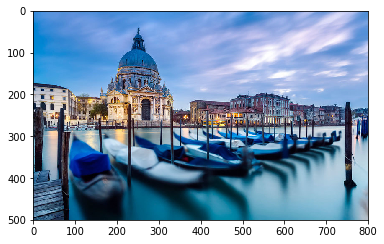

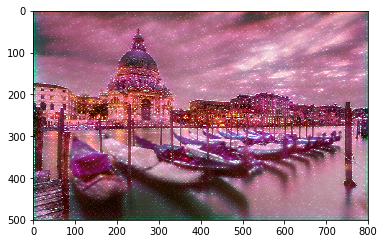

In [10]:
content_image = tf.keras.preprocessing.image.img_to_array(img=tf.keras.preprocessing.image.load_img(CONTENT_IMG))

tf.reset_default_graph()
eval_graph = tf.Graph()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with eval_graph.as_default() as g, tf.Session(config=config, graph=eval_graph) as sess:  
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], MODEL_DIR)
    inputs = g.get_tensor_by_name("inputs:0")
    outputs = g.get_tensor_by_name("outputs:0")    
    c = sess.run(tf.expand_dims(content_image, axis=0))
    start = time.time()
    result = sess.run(tf.squeeze(outputs), feed_dict={inputs: c})
    end = time.time()
    print("Inference time: {time} seconds".format(time=end-start))
    
plt.imshow(content_image / 255.)    
plt.show()

plt.imshow(result / 255.)    
plt.show()

### 11. Commentary

In this notebook, we are trying to replicate Justin's work in his paper "Perceptual Losses for Real-Time Style Transfer and Super-Resolution". He suggested the training of transformation network with guidance of vgg as loss network in style transfer instead of optimization method using deep network. This means during inference, only the transformation network is responsible for the style transfer thus the inference time depends on the complexity of the transformation network alone (0.07 seconds using Justin's architecture). 

There is a caveat here, since during training we are only using a single style image to guide the network then the mapping of style-network is one to one meaning one network can only transfer a single style, imagine an application that needs 1000 styles will need 1000 distinct networks. Some new architectures have been developed to tackle this problem since then, we will cover some of them in the next parts.

### 12. Resources

1. Perceptual Losses for Real-Time Style Transfer and Super-Resolution [https://arxiv.org/abs/1603.08155](https://arxiv.org/abs/1603.08155)
2. Tensorflow vgg model and weights [http://www.cs.toronto.edu/~frossard/post/vgg16/](http://www.cs.toronto.edu/~frossard/post/vgg16/)
3. Using tensorflow saved_model [magenta](https://github.com/tensorflow/magenta/pull/796/commits/c3cb5ea8c40976be7bdc672e03639ab370a2399f), [stackoverflow](https://stackoverflow.com/questions/45705070/how-to-load-and-use-a-saved-model-on-tensorflow)